In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.metrics import pairwise_distances
from Levenshtein import distance as levenshtein_distance
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns
from cluster_tools import pure_clusters_fraction
from cluster_tools import pure_cluster_retention
from sklearn.metrics import adjusted_rand_score,silhouette_score,normalized_mutual_info_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [17]:
# Load your data
alpha_chain_data = pd.read_csv('..\pre-processing final\cdr3_alpha_df.csv')
beta_chain_data = pd.read_csv('..\pre-processing final\cdr3_beta_df.csv')
alpha_beta_chain = pd.read_csv('..\pre-processing final\cdr3_alpha_beta_df.csv')

In [18]:
# Function to calculate the pairwise Levenshtein distance matrix
def levenshtein_distance_matrix(sequences):
    length = len(sequences)
    dist_matrix = np.zeros((length, length))
    for i in range(length):
        for j in range(i + 1, length):  # Use symmetry to save computation
            dist = levenshtein_distance(sequences[i], sequences[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

In [19]:
# 定义保存函数，使用 DataFrame 来保存 CSV
def save_distance_matrix_to_csv(distance_matrix, filename):
    df = pd.DataFrame(distance_matrix)
    df.to_csv(filename, index=False, header=False)  # 不保存行列的索引

In [ ]:
# Extract CDR3 sequences
alpha_homoSapiens_sequences = alpha_chain_data.loc[alpha_chain_data['species'] == 'HomoSapiens', ['cdr3_a_aa', 'v_a_gene', 'j_a_gene']].values.tolist()
alpha_musMusculus_sequences = alpha_chain_data.loc[alpha_chain_data['species'] == 'MusMusculus', ['cdr3_a_aa', 'v_a_gene', 'j_a_gene']].values.tolist()

beta_homoSapiens_sequences = beta_chain_data.loc[beta_chain_data['species'] == 'HomoSapiens', ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']].values.tolist()
beta_musMusculus_sequences = beta_chain_data.loc[beta_chain_data['species'] == 'MusMusculus', ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']].values.tolist()

# alpha_beta_homoSapiens_sequences = [a + b for a, b in zip(
#     alpha_chain_data.loc[alpha_chain_data['species'] == 'HomoSapiens', ['cdr3_a_aa', 'v_a_gene', 'j_a_gene']].values.tolist(),
#     beta_chain_data.loc[beta_chain_data['species'] == 'HomoSapiens', ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']].values.tolist())]

# alpha_beta_musMusculus_sequences = [a + b for a, b in zip(
#     alpha_chain_data.loc[alpha_chain_data['species'] == 'MusMusculus', ['cdr3_a_aa',  'v_a_gene', 'j_a_gene']].values.tolist(),
#     beta_chain_data.loc[beta_chain_data['species'] == 'MusMusculus', ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']].values.tolist())]


alpha_homoSapiens_distance_matrix = levenshtein_distance_matrix(alpha_homoSapiens_sequences)
alpha_musMusculus_distance_matrix = levenshtein_distance_matrix(alpha_musMusculus_sequences)
beta_homoSapiens_distance_matrix = levenshtein_distance_matrix(beta_homoSapiens_sequences)
beta_musMusculus_distance_matrix = levenshtein_distance_matrix(beta_musMusculus_sequences)
# alpha_beta_homoSapiens_distance_matrix = levenshtein_distance_matrix(alpha_beta_homoSapiens_sequences)
# alpha_beta_musMusculus_distance_matrix = levenshtein_distance_matrix(alpha_beta_musMusculus_sequences)

# Save file
save_distance_matrix_to_csv(alpha_homoSapiens_distance_matrix, "Distance calculation methods/levenshtein distance calculation/alpha_homoSapiens_distance_matrix.csv")
save_distance_matrix_to_csv(alpha_musMusculus_distance_matrix, "Distance calculation methods/levenshtein distance calculation/alpha_musMusculus_distance_matrix.csv")
save_distance_matrix_to_csv(beta_homoSapiens_distance_matrix, "Distance calculation methods/levenshtein distance calculation/beta_homoSapiens_distance_matrix.csv")
save_distance_matrix_to_csv(beta_musMusculus_distance_matrix, "Distance calculation methods/levenshtein distance calculation/beta_musMusculus_distance_matrix.csv")
# save_distance_matrix_to_csv(alpha_beta_homoSapiens_distance_matrix, "/content/drive/MyDrive/alpha_beta_homoSapiens_distance_matrix.csv")
# save_distance_matrix_to_csv(alpha_beta_musMusculus_distance_matrix, "/content/drive/MyDrive/alpha_beta_musMusculus_distance_matrix.csv")

In [ ]:
# Compute the distance matrices
# alpha_cdr3_sequences = alpha_homoSapiens_sequences + alpha_musMusculus_sequences
# beta_cdr3_sequences = beta_homoSapiens_sequences + beta_musMusculus_sequences
# alpha_beta_sequences = alpha_beta_homoSapiens_sequences + alpha_beta_musMusculus_sequences

# alpha_distance_matrix = levenshtein_distance_matrix(alpha_cdr3_sequences)
# beta_distance_matrix = levenshtein_distance_matrix(beta_cdr3_sequences)
# alpha_beta_distance_matrix = levenshtein_distance_matrix(alpha_beta_sequences)

alpha_beta_homoSapiens_distance_matrix = alpha_homoSapiens_distance_matrix + beta_homoSapiens_distance_matrix
alpha_beta_musMusculus_distance_matrix = alpha_musMusculus_distance_matrix = beta_musMusculus_distance_matrix

#Save the matrices to CSV files
save_distance_matrix_to_csv(alpha_beta_homoSapiens_distance_matrix, "Distance calculation methods/levenshtein distance calculation/alpha_beta_homoSapiens_distance_matrix.csv")
save_distance_matrix_to_csv(alpha_beta_musMusculus_distance_matrix, "Distance calculation methods/levenshtein distance calculation/alpha_beta_musMusculus_distance_matrix.csv")

In [22]:
def load_distance_matrix(filename):
    return pd.read_csv(filename, header=None, index_col=None).values
# load data
alpha_homoSapiens_distance_matrix = load_distance_matrix('..\Distance calculation methods/levenshtein distance calculation/alpha_homoSapiens_distance_matrix.csv')
alpha_musMusculus_distance_matrix = load_distance_matrix('..\Distance calculation methods/levenshtein distance calculation/alpha_musMusculus_distance_matrix.csv')
beta_homoSapiens_distance_matrix = load_distance_matrix('..\Distance calculation methods/levenshtein distance calculation/beta_homoSapiens_distance_matrix.csv')
beta_musMusculus_distance_matrix = load_distance_matrix('..\Distance calculation methods/levenshtein distance calculation/beta_musMusculus_distance_matrix.csv')
alpha_beta_homoSapiens_distance_matrix = load_distance_matrix('..\Distance calculation methods/levenshtein distance calculation/alpha_beta_homoSapiens_distance_matrix.csv')
alpha_beta_musMusculus_distance_matrix = load_distance_matrix('..\Distance calculation methods/levenshtein distance calculation/alpha_beta_musMusculus_distance_matrix.csv')

In [23]:
#Define a dictionary to store matrix names
distance_matrices = [
    (alpha_homoSapiens_distance_matrix, 'alpha_homoSapiens_distance_matrix'),
    (alpha_musMusculus_distance_matrix, 'alpha_musMusculus_distance_matrix'),
    (beta_homoSapiens_distance_matrix, 'beta_homoSapiens_distance_matrix.csv'),
    (beta_musMusculus_distance_matrix, 'beta_musMusculus_distance_matrix.csv'),
    (alpha_beta_homoSapiens_distance_matrix, 'alpha_beta_homoSapiens_distance_matrix'),
    (alpha_beta_musMusculus_distance_matrix, 'alpha_beta_musMusculus_distance_matrix')
    ]

In [ ]:
# transform the distance matrix into a condensed distance matrix
# perform hierarchical clustering
for distance_matrix, label in distance_matrices:
    # Convert distance matrix to compressed format
    condensed_dist_matrix = squareform(distance_matrix)

    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_dist_matrix, method='ward')

    # Create a DataFrame to hold the linkage matrix
    linkage_df = pd.DataFrame(linkage_matrix, columns=['Cluster1', 'Cluster2', 'Distance', 'New Cluster Size'])

    # Save DataFrame as CSV file
    linkage_df.to_csv(f'Distance calculation methods/levenshtein distance calculation/linkage_matrix_{label}.csv', index=True)

In [ ]:
# Load distance matrix
for matrix, label in distance_matrices:
    # Create a clusterer, here using precomputed distances
    clustering = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='complete')
    # Perform clustering
    clustering.fit(matrix)
    # Create a DataFrame to save clustering results
    labels = pd.DataFrame(clustering.labels_, columns=['ClusterLabel'])
    # Save clustering results
    labels.to_csv(f'Distance calculation methods/levenshtein distance calculation/{label}_labels.csv', index=True)


Calculating silhouette scores for alpha_homoSapiens_distance_matrix


e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

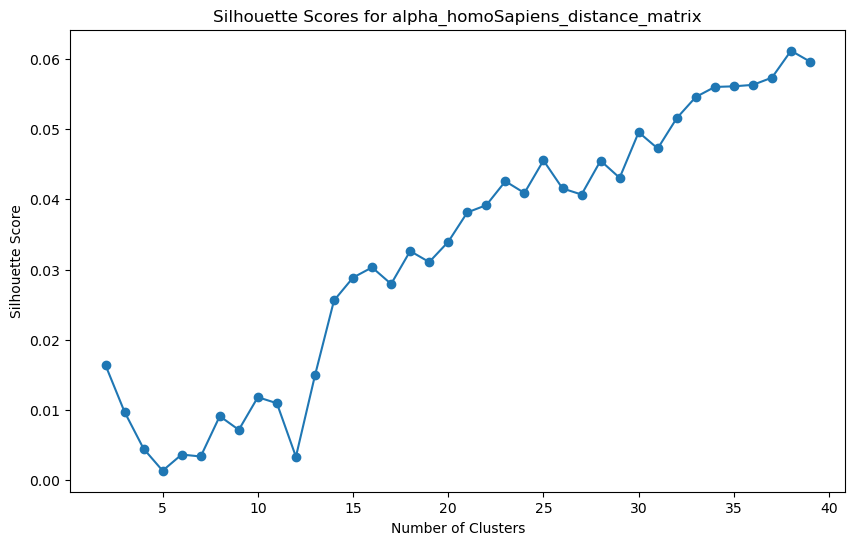

Calculating silhouette scores for alpha_musMusculus_distance_matrix


e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

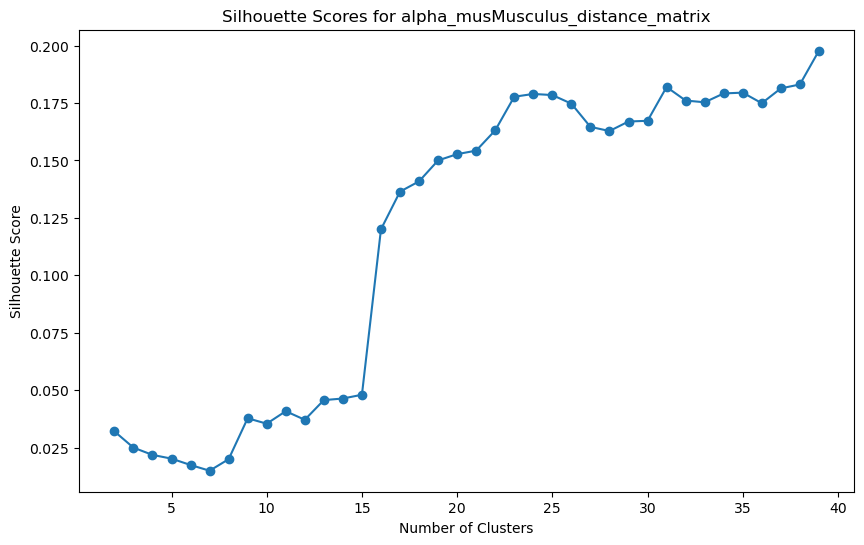

Calculating silhouette scores for beta_homoSapiens_distance_matrix.csv


e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

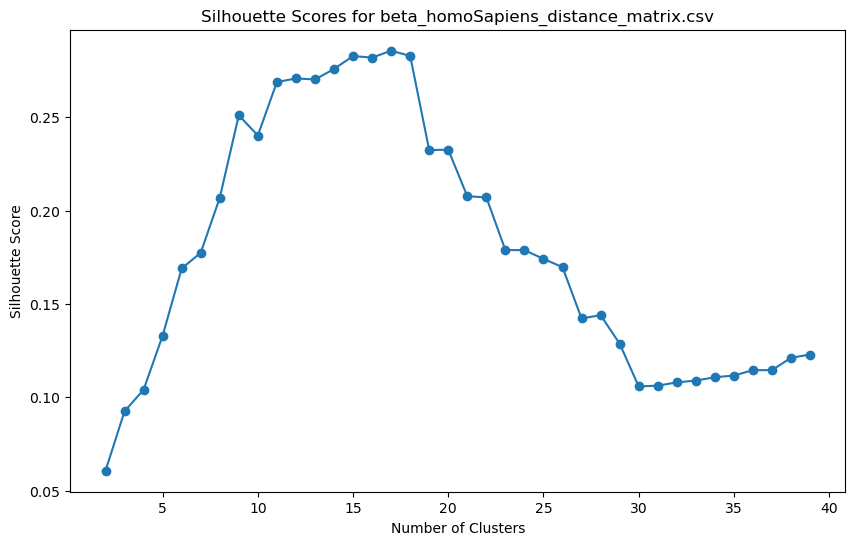

Calculating silhouette scores for beta_musMusculus_distance_matrix.csv


e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

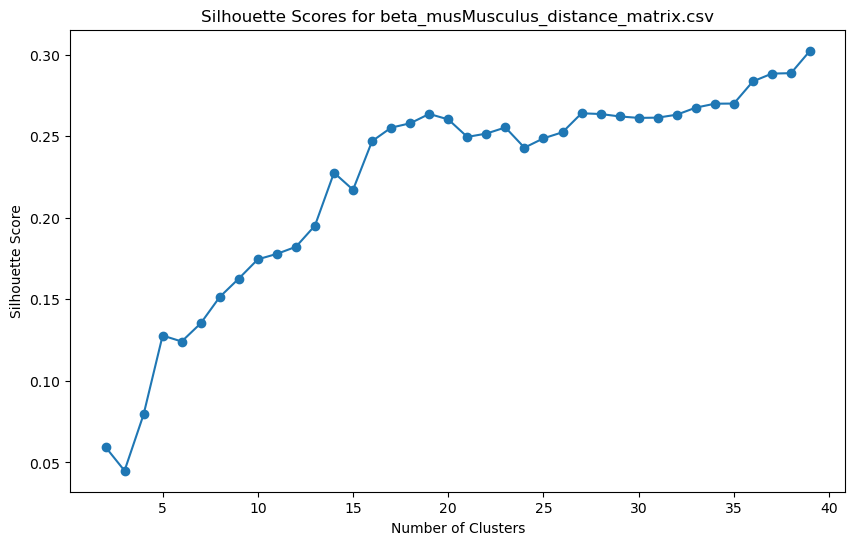

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Calculating silhouette scores for alpha_beta_homoSapiens_distance_matrix


e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

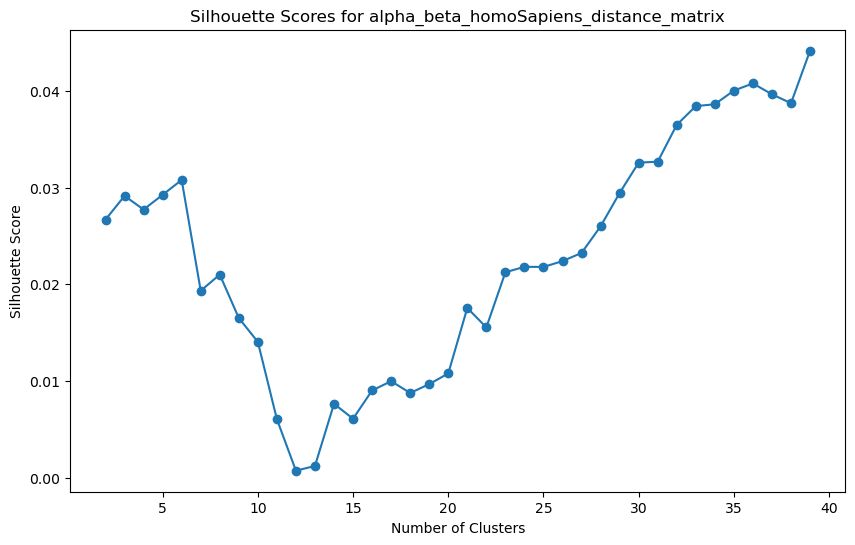

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Calculating silhouette scores for alpha_beta_musMusculus_distance_matrix


e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

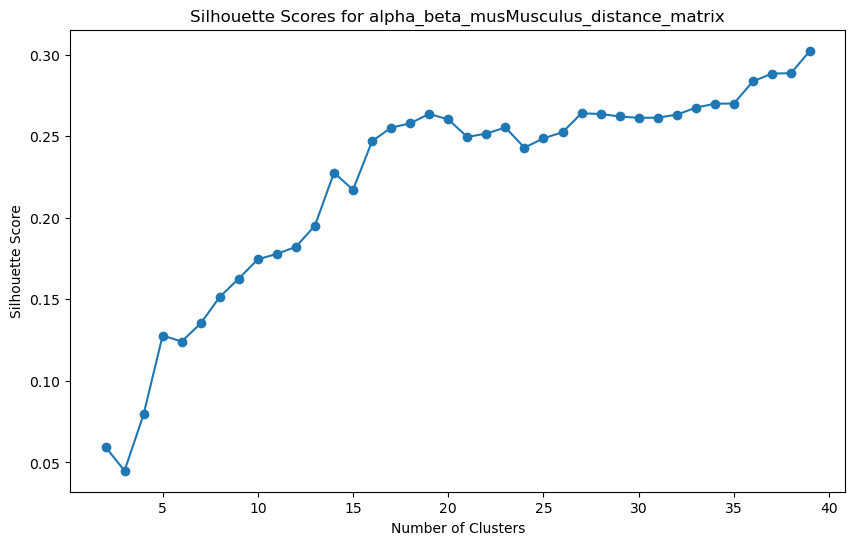

In [25]:
# Loop over each distance matrix and calculate silhouette scores for a range of cluster numbers
for matrix, label in distance_matrices:
    print(f"Calculating silhouette scores for {label}")
    silhouette_scores = []
    cluster_range = range(2, 40)
    # Iterate through the range of cluster numbers
    for n_clusters in cluster_range:
        # Create a clustering instance with the specified number of clusters
        clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')

        # Fit the clustering instance to the data and predict the labels
        labels = clustering.fit_predict(matrix)

        # Calculate the silhouette score for the current number of clusters
        score = silhouette_score(matrix, labels, metric='precomputed')
        silhouette_scores.append(score)
        
    
        #print(f'Number of Clusters: {n_clusters}, Silhouette Score: {score}')

    # Plot the elbow graph for the current distance matrix
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.title(f'Silhouette Scores for {label}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

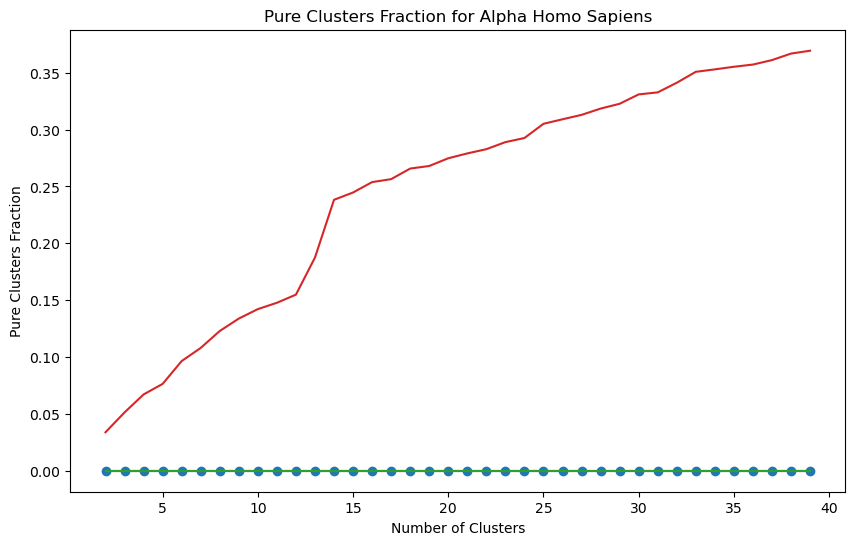

In [26]:
epitope = alpha_chain_data.loc[alpha_chain_data['species'] == 'HomoSapiens','epitope'].values
distance_matrice = alpha_homoSapiens_distance_matrix

# Define range of cluster numbers to try
cluster_range = range(2, 40)  # From 2 to 40 clusters
pure_cluster_fractions = []
purity_fraction = []
purity_retention = []
nmi=[]

# Calculate pure clusters fraction for each cluster number
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrice)
    pure_fraction = pure_clusters_fraction(labels, epitope)
    pure_cluster_fractions.append(pure_fraction)
    purity_fraction.append(pure_clusters_fraction(labels, epitope))
    purity_retention.append(pure_cluster_retention(labels, epitope))
    nmi.append(normalized_mutual_info_score(epitope, labels))

# Plot the pure clusters fraction as an elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(cluster_range), pure_cluster_fractions, marker='o')
plt.plot(cluster_range, purity_fraction, label='Purity Fraction')
plt.plot(cluster_range, purity_retention, label='Purity Retention')
plt.plot(cluster_range, nmi, label='NMI')
plt.title('Pure Clusters Fraction for Alpha Homo Sapiens')
plt.xlabel('Number of Clusters')
plt.ylabel('Pure Clusters Fraction')
plt.show()

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

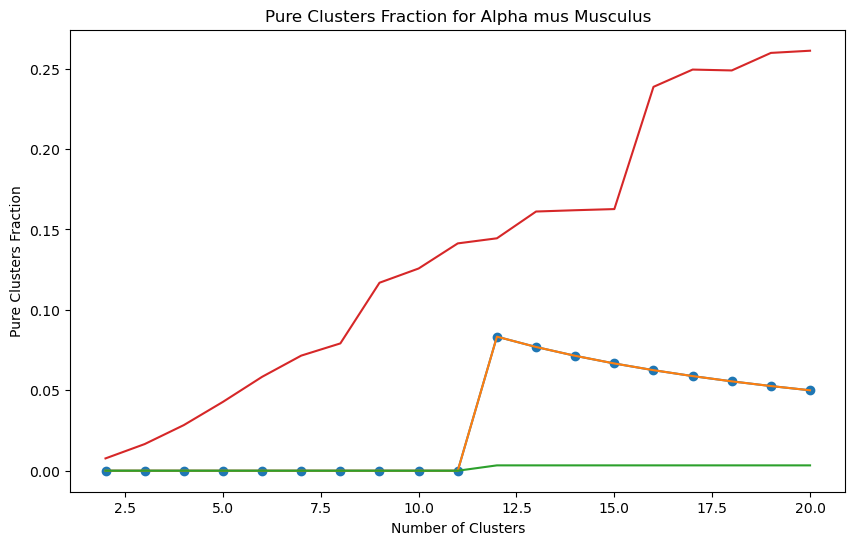

In [29]:
epitope = alpha_chain_data.loc[alpha_chain_data['species'] == 'MusMusculus','epitope'].values
distance_matrice = alpha_musMusculus_distance_matrix

# Define range of cluster numbers to try
cluster_range = range(2, 40)  # From 2 to 40 clusters
pure_cluster_fractions = []
purity_fraction = []
purity_retention = []
nmi=[]

# Calculate pure clusters fraction for each cluster number
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrice)
    pure_fraction = pure_clusters_fraction(labels, epitope)
    pure_cluster_fractions.append(pure_fraction)
    purity_fraction.append(pure_clusters_fraction(labels, epitope))
    purity_retention.append(pure_cluster_retention(labels, epitope))
    nmi.append(normalized_mutual_info_score(epitope, labels))

# Plot the pure clusters fraction as an elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(cluster_range), pure_cluster_fractions, marker='o')
plt.plot(cluster_range, purity_fraction, label='Purity Fraction')
plt.plot(cluster_range, purity_retention, label='Purity Retention')
plt.plot(cluster_range, nmi, label='NMI')
plt.title('Pure Clusters Fraction for Alpha mus Musculus')
plt.xlabel('Number of Clusters')
plt.ylabel('Pure Clusters Fraction')
plt.show()

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

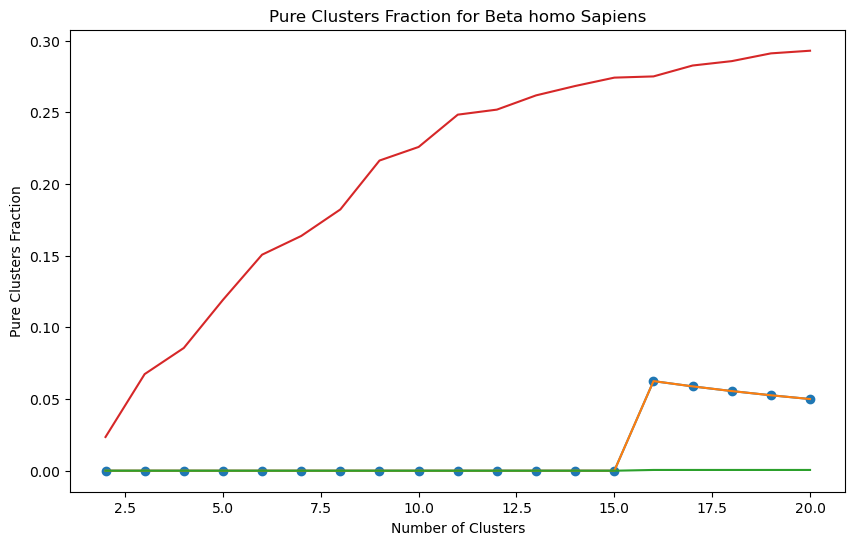

In [31]:
epitope = beta_chain_data.loc[beta_chain_data['species'] == 'HomoSapiens','epitope'].values
distance_matrice = beta_homoSapiens_distance_matrix

# Define range of cluster numbers to try
cluster_range = range(2, 40)  # From 2 to 40 clusters
pure_cluster_fractions = []
purity_fraction = []
purity_retention = []
nmi=[]

# Calculate pure clusters fraction for each cluster number
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrice)
    pure_fraction = pure_clusters_fraction(labels, epitope)
    pure_cluster_fractions.append(pure_fraction)
    purity_fraction.append(pure_clusters_fraction(labels, epitope))
    purity_retention.append(pure_cluster_retention(labels, epitope))
    nmi.append(normalized_mutual_info_score(epitope, labels))

# Plot the pure clusters fraction as an elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(cluster_range), pure_cluster_fractions, marker='o')
plt.plot(cluster_range, purity_fraction, label='Purity Fraction')
plt.plot(cluster_range, purity_retention, label='Purity Retention')
plt.plot(cluster_range, nmi, label='NMI')
plt.title('Pure Clusters Fraction for Beta homo Sapiens')
plt.xlabel('Number of Clusters')
plt.ylabel('Pure Clusters Fraction')
plt.show()

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

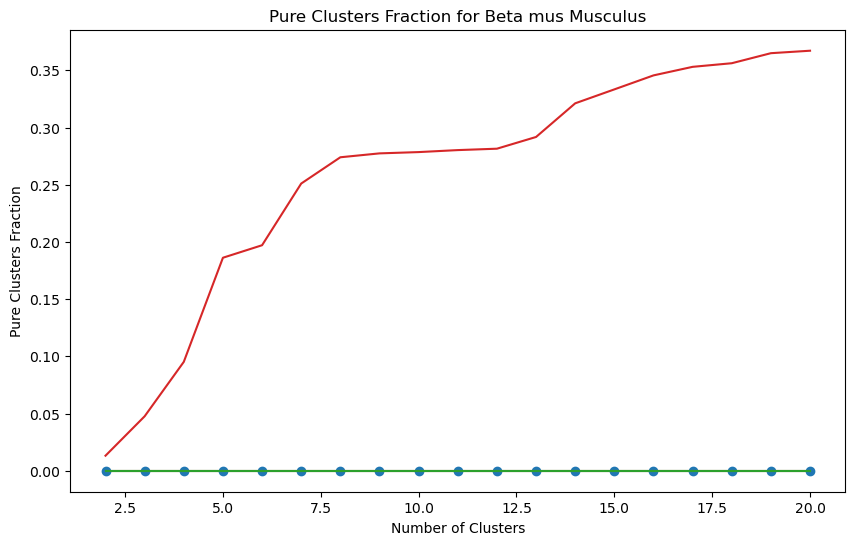

In [30]:
epitope = beta_chain_data.loc[beta_chain_data['species'] == 'MusMusculus','epitope'].values
distance_matrice = beta_musMusculus_distance_matrix

# Define range of cluster numbers to try
cluster_range = range(2, 40)  # From 2 to 40 clusters
pure_cluster_fractions = []
purity_fraction = []
purity_retention = []
nmi=[]

# Calculate pure clusters fraction for each cluster number
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrice)
    pure_fraction = pure_clusters_fraction(labels, epitope)
    pure_cluster_fractions.append(pure_fraction)
    purity_fraction.append(pure_clusters_fraction(labels, epitope))
    purity_retention.append(pure_cluster_retention(labels, epitope))
    nmi.append(normalized_mutual_info_score(epitope, labels))

# Plot the pure clusters fraction as an elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(cluster_range), pure_cluster_fractions, marker='o')
plt.plot(cluster_range, purity_fraction, label='Purity Fraction')
plt.plot(cluster_range, purity_retention, label='Purity Retention')
plt.plot(cluster_range, nmi, label='NMI')
plt.title('Pure Clusters Fraction for Beta mus Musculus')
plt.xlabel('Number of Clusters')
plt.ylabel('Pure Clusters Fraction')
plt.show()

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

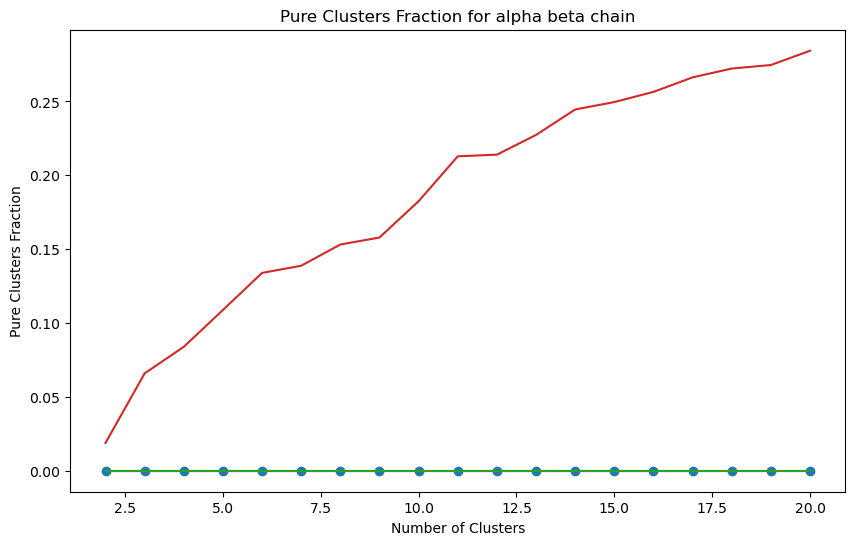

In [32]:
epitope = alpha_beta_chain.loc[alpha_beta_chain['species'] == 'HomoSapiens','epitope'].values
distance_matrice = alpha_beta_homoSapiens_distance_matrix

# Define range of cluster numbers to try
cluster_range = range(2, 40)  # From 2 to 40 clusters
pure_cluster_fractions = []
purity_fraction = []
purity_retention = []
nmi=[]

# Calculate pure clusters fraction for each cluster number
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrice)
    pure_fraction = pure_clusters_fraction(labels, epitope)
    pure_cluster_fractions.append(pure_fraction)
    purity_fraction.append(pure_clusters_fraction(labels, epitope))
    purity_retention.append(pure_cluster_retention(labels, epitope))
    nmi.append(normalized_mutual_info_score(epitope, labels))

# Plot the pure clusters fraction as an elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(cluster_range), pure_cluster_fractions, marker='o')
plt.plot(cluster_range, purity_fraction, label='Purity Fraction')
plt.plot(cluster_range, purity_retention, label='Purity Retention')
plt.plot(cluster_range, nmi, label='NMI')
plt.title('Pure Clusters Fraction for alpha beta chain')
plt.xlabel('Number of Clusters')
plt.ylabel('Pure Clusters Fraction')
plt.show()

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

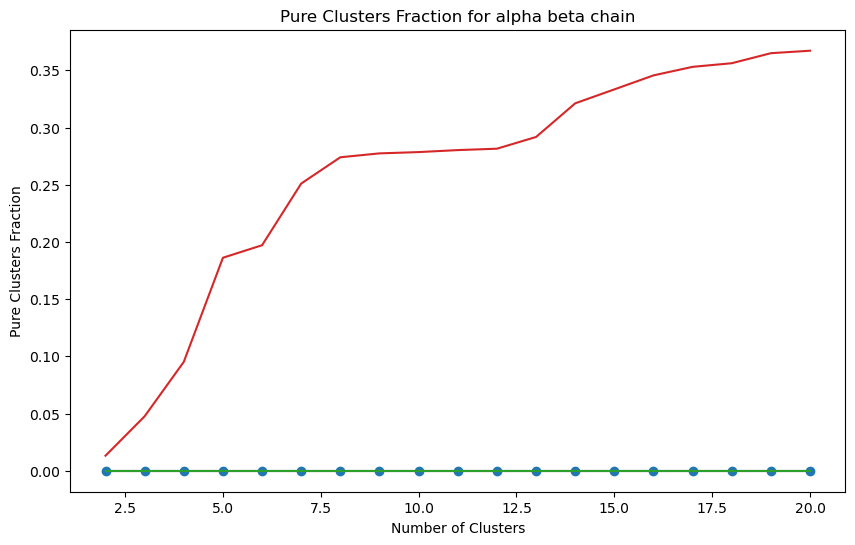

In [34]:
epitope = alpha_beta_chain.loc[alpha_beta_chain['species'] == 'MusMusculus','epitope'].values
distance_matrice = alpha_beta_musMusculus_distance_matrix

# Define range of cluster numbers to try
cluster_range = range(2, 40)  # From 2 to 40 clusters
pure_cluster_fractions = []
purity_fraction = []
purity_retention = []
nmi=[]

# Calculate pure clusters fraction for each cluster number
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrice)
    pure_fraction = pure_clusters_fraction(labels, epitope)
    pure_cluster_fractions.append(pure_fraction)
    purity_fraction.append(pure_clusters_fraction(labels, epitope))
    purity_retention.append(pure_cluster_retention(labels, epitope))
    nmi.append(normalized_mutual_info_score(epitope, labels))

# Plot the pure clusters fraction as an elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(cluster_range), pure_cluster_fractions, marker='o')
plt.plot(cluster_range, purity_fraction, label='Purity Fraction')
plt.plot(cluster_range, purity_retention, label='Purity Retention')
plt.plot(cluster_range, nmi, label='NMI')
plt.title('Pure Clusters Fraction for alpha beta chain')
plt.xlabel('Number of Clusters')
plt.ylabel('Pure Clusters Fraction')
plt.show()

In [30]:
#使用np读取npy文件
alpha_homoSapiens_distance_matrix = np.load('..\Distance calculation methods/TCRdist/human_df_alpha_TCRs_distance_matrix.npy')
alpha_musMusculus_distance_matrix = np.load('..\Distance calculation methods/TCRdist/mouse_df_alpha_TCRs_distance_matrix.npy')
beta_homoSapiens_distance_matrix = np.load('..\Distance calculation methods/TCRdist/human_df_beta_TCRs_distance_matrix.npy')
beta_musMusculus_distance_matrix = np.load('..\Distance calculation methods/TCRdist/mouse_df_beta_TCRs_distance_matrix.npy')
alpha_beta_homoSapiens_distance_matrix = np.load('..\Distance calculation methods/TCRdist/human_df_alpha_beta_TCRs_distance_matrix.npy')
alpha_beta_musMusculus_distance_matrix = np.load('..\Distance calculation methods/TCRdist/mouse_df_alpha_beta_TCRs_distance_matrix.npy')

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

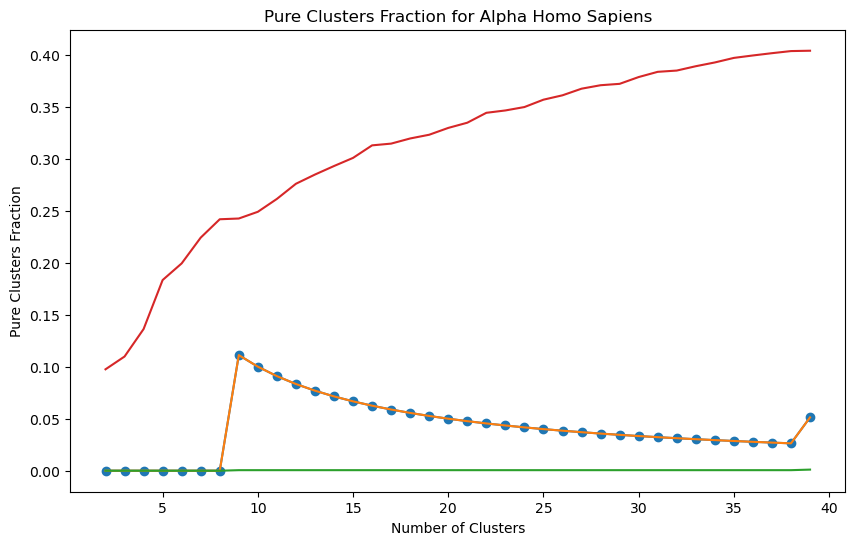

In [31]:
epitope = alpha_chain_data.loc[alpha_chain_data['species'] == 'HomoSapiens','epitope'].values
distance_matrice = alpha_homoSapiens_distance_matrix

# Define range of cluster numbers to try
cluster_range = range(2, 40)  # From 2 to 40 clusters
pure_cluster_fractions = []
purity_fraction = []
purity_retention = []
nmi=[]

# Calculate pure clusters fraction for each cluster number
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrice)
    pure_fraction = pure_clusters_fraction(labels, epitope)
    pure_cluster_fractions.append(pure_fraction)
    purity_fraction.append(pure_clusters_fraction(labels, epitope))
    purity_retention.append(pure_cluster_retention(labels, epitope))
    nmi.append(normalized_mutual_info_score(epitope, labels))

# Plot the pure clusters fraction as an elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(cluster_range), pure_cluster_fractions, marker='o')
plt.plot(cluster_range, purity_fraction, label='Purity Fraction')
plt.plot(cluster_range, purity_retention, label='Purity Retention')
plt.plot(cluster_range, nmi, label='NMI')
plt.title('Pure Clusters Fraction for Alpha Homo Sapiens')
plt.xlabel('Number of Clusters')
plt.ylabel('Pure Clusters Fraction')
plt.show()

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

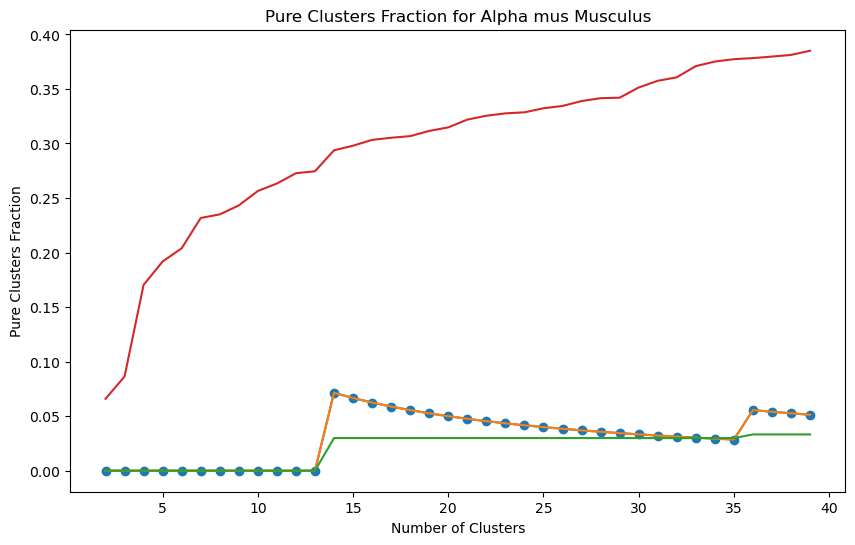

In [32]:
epitope = alpha_chain_data.loc[alpha_chain_data['species'] == 'MusMusculus','epitope'].values
distance_matrice = alpha_musMusculus_distance_matrix

# Define range of cluster numbers to try
cluster_range = range(2, 40)  # From 2 to 40 clusters
pure_cluster_fractions = []
purity_fraction = []
purity_retention = []
nmi=[]

# Calculate pure clusters fraction for each cluster number
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrice)
    pure_fraction = pure_clusters_fraction(labels, epitope)
    pure_cluster_fractions.append(pure_fraction)
    purity_fraction.append(pure_clusters_fraction(labels, epitope))
    purity_retention.append(pure_cluster_retention(labels, epitope))
    nmi.append(normalized_mutual_info_score(epitope, labels))

# Plot the pure clusters fraction as an elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(cluster_range), pure_cluster_fractions, marker='o')
plt.plot(cluster_range, purity_fraction, label='Purity Fraction')
plt.plot(cluster_range, purity_retention, label='Purity Retention')
plt.plot(cluster_range, nmi, label='NMI')
plt.title('Pure Clusters Fraction for Alpha mus Musculus')
plt.xlabel('Number of Clusters')
plt.ylabel('Pure Clusters Fraction')
plt.show()

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

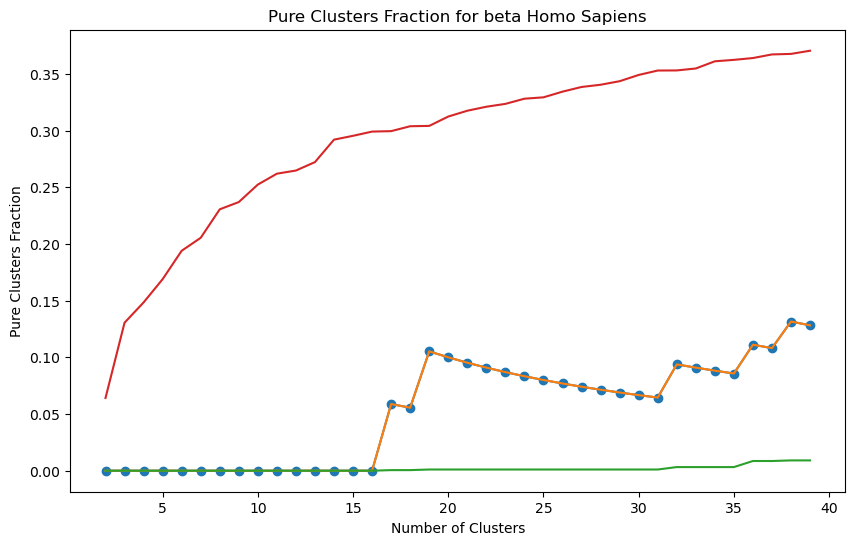

In [35]:
epitope = beta_chain_data.loc[beta_chain_data['species'] == 'HomoSapiens','epitope'].values
distance_matrice = beta_homoSapiens_distance_matrix

# Define range of cluster numbers to try
cluster_range = range(2, 40)  # From 2 to 20 clusters
pure_cluster_fractions = []
purity_fraction = []
purity_retention = []
nmi=[]

# Calculate pure clusters fraction for each cluster number
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrice)
    pure_fraction = pure_clusters_fraction(labels, epitope)
    pure_cluster_fractions.append(pure_fraction)
    purity_fraction.append(pure_clusters_fraction(labels, epitope))
    purity_retention.append(pure_cluster_retention(labels, epitope))
    nmi.append(normalized_mutual_info_score(epitope, labels))

# Plot the pure clusters fraction as an elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(cluster_range), pure_cluster_fractions, marker='o')
plt.plot(cluster_range, purity_fraction, label='Purity Fraction')
plt.plot(cluster_range, purity_retention, label='Purity Retention')
plt.plot(cluster_range, nmi, label='NMI')
plt.title('Pure Clusters Fraction for beta Homo Sapiens')
plt.xlabel('Number of Clusters')
plt.ylabel('Pure Clusters Fraction')
plt.show()

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

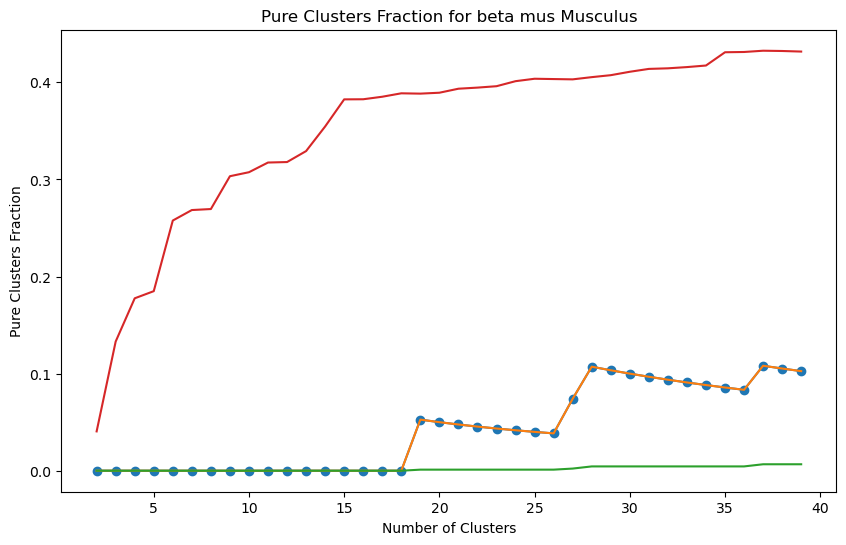

In [37]:
epitope = beta_chain_data.loc[beta_chain_data['species'] == 'MusMusculus','epitope'].values
distance_matrice = beta_musMusculus_distance_matrix

# Define range of cluster numbers to try
cluster_range = range(2, 40)  # From 2 to 20 clusters
pure_cluster_fractions = []
purity_fraction = []
purity_retention = []
nmi=[]

# Calculate pure clusters fraction for each cluster number
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrice)
    pure_fraction = pure_clusters_fraction(labels, epitope)
    pure_cluster_fractions.append(pure_fraction)
    purity_fraction.append(pure_clusters_fraction(labels, epitope))
    purity_retention.append(pure_cluster_retention(labels, epitope))
    nmi.append(normalized_mutual_info_score(epitope, labels))

# Plot the pure clusters fraction as an elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(cluster_range), pure_cluster_fractions, marker='o')
plt.plot(cluster_range, purity_fraction, label='Purity Fraction')
plt.plot(cluster_range, purity_retention, label='Purity Retention')
plt.plot(cluster_range, nmi, label='NMI')
plt.title('Pure Clusters Fraction for beta mus Musculus')
plt.xlabel('Number of Clusters')
plt.ylabel('Pure Clusters Fraction')
plt.show()

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

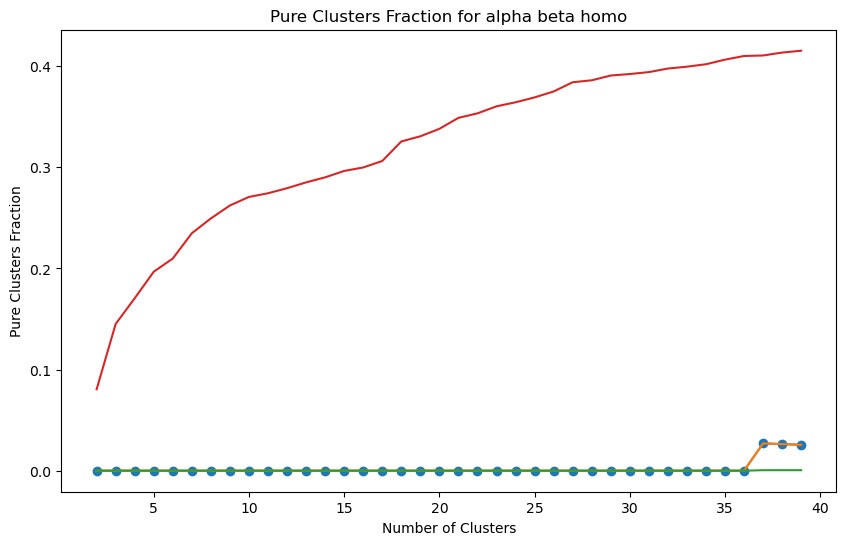

In [38]:
epitope = alpha_beta_chain.loc[alpha_beta_chain['species'] == 'HomoSapiens','epitope'].values
distance_matrice = alpha_beta_homoSapiens_distance_matrix

# Define range of cluster numbers to try
cluster_range = range(2, 40)  # From 2 to 40 clusters
pure_cluster_fractions = []
purity_fraction = []
purity_retention = []
nmi=[]

# Calculate pure clusters fraction for each cluster number
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrice)
    pure_fraction = pure_clusters_fraction(labels, epitope)
    pure_cluster_fractions.append(pure_fraction)
    purity_fraction.append(pure_clusters_fraction(labels, epitope))
    purity_retention.append(pure_cluster_retention(labels, epitope))
    nmi.append(normalized_mutual_info_score(epitope, labels))

# Plot the pure clusters fraction as an elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(cluster_range), pure_cluster_fractions, marker='o')
plt.plot(cluster_range, purity_fraction, label='Purity Fraction')
plt.plot(cluster_range, purity_retention, label='Purity Retention')
plt.plot(cluster_range, nmi, label='NMI')
plt.title('Pure Clusters Fraction for alpha beta homo')
plt.xlabel('Number of Clusters')
plt.ylabel('Pure Clusters Fraction')
plt.show()

e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warni

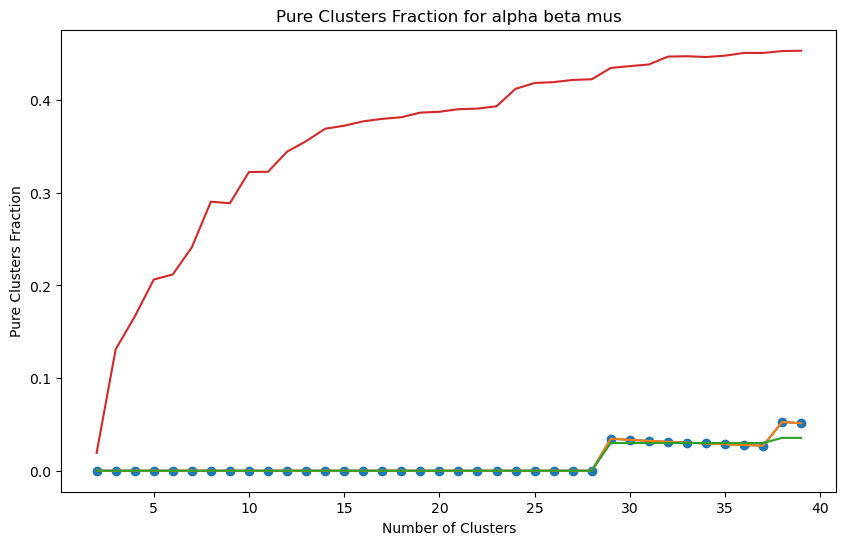

In [39]:
epitope = alpha_beta_chain.loc[alpha_beta_chain['species'] == 'MusMusculus','epitope'].values
distance_matrice = alpha_beta_musMusculus_distance_matrix

# Define range of cluster numbers to try
cluster_range = range(2, 40)  # From 2 to 20 clusters
pure_cluster_fractions = []
purity_fraction = []
purity_retention = []
nmi=[]

# Calculate pure clusters fraction for each cluster number
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')
    labels = clustering.fit_predict(distance_matrice)
    pure_fraction = pure_clusters_fraction(labels, epitope)
    pure_cluster_fractions.append(pure_fraction)
    purity_fraction.append(pure_clusters_fraction(labels, epitope))
    purity_retention.append(pure_cluster_retention(labels, epitope))
    nmi.append(normalized_mutual_info_score(epitope, labels))

# Plot the pure clusters fraction as an elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(cluster_range), pure_cluster_fractions, marker='o')
plt.plot(cluster_range, purity_fraction, label='Purity Fraction')
plt.plot(cluster_range, purity_retention, label='Purity Retention')
plt.plot(cluster_range, nmi, label='NMI')
plt.title('Pure Clusters Fraction for alpha beta mus')
plt.xlabel('Number of Clusters')
plt.ylabel('Pure Clusters Fraction')
plt.show()